In [ ]:
import os
import sys


sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), "src")))


In [ ]:
import torch
import numpy as np


# env_name = "button-press-topdown-v2"
env_name = "box-close-v2"
# env_name = "dial-turn-v2"
# env_name = "sweep-v2"
# env_name = "lever-pull-v2"
exp_name = "CUDA-01-00"
pair_algo = "ternary-500"
# reward_model_algo = "MR-exp"
reward_model_algo = "MR-linear"
test_pair_algo = "ternary-500-aug-10000-bucket-knn-ratio-10-20-uncert-3.1"

os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

TRAJECTORY_LENGTH = 25

In [ ]:
from data_generation.data_research import predict_rewards
from data_loading.load_data import load_dataset


def predict_only_rewards(
    env_name,
    exp_name,
    pair_algo,
    reward_model_algo,
):
    result = predict_rewards(
        env_name=env_name,
        exp_name=exp_name,
        pair_algo=pair_algo,
        reward_model_algo=reward_model_algo,
    )

    pred_reward_list = [r for (_, r, _, _) in result]
    pred_reward_list = np.array(pred_reward_list)

    return pred_reward_list

# True reward
dataset = load_dataset(
    env_name=env_name,
)
cumsum = np.cumsum(dataset["rewards"], dtype=np.float64)
average_reward = np.mean(dataset["rewards"])

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def get_reward_from_cumsum(start, end):
    """
    Get the reward from the cumulative sum between start and end indices.
    """

    if start == 0:
        return cumsum[end - 1]
    else:
        return cumsum[end - 1] - cumsum[start - 1]

def get_total_reward(s, e, reward_cumsum):
    return reward_cumsum[e - 1] - (reward_cumsum[s - 1] if s > 0 else 0)

def get_bucket_index(reward, bucket_ranges):
    for i, (low, high) in enumerate(bucket_ranges):
        if low <= reward <= high:  
            return i
    return None 

In [16]:
from matplotlib import gridspec, pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from data_loading.load_data import load_pair


def eval_feedbacks(feedbacks, test_pair_algo="default", unlabel_pair="unlabel-100000"):
    traj_truth_rewards = []
    unlabel_pairs = load_pair(
        env_name=env_name,
        exp_name=exp_name,
        pair_type="train",
        pair_algo=unlabel_pair,
    )
    raw_traj_truth_rewards = []
    for p in unlabel_pairs:
        (s0, e0), (s1, e1), _ = p
        raw_traj_truth_rewards.append(get_reward_from_cumsum(s0, e0))
        raw_traj_truth_rewards.append(get_reward_from_cumsum(s1, e1))

    total = 0
    correct = 0
    bins = 25
    bin_edges = np.linspace(0, 250, bins + 1)

    r0_list = []
    r1_list = []
    mask_map = np.zeros((bins, bins))
    correct_map = np.zeros((bins, bins))
    count_map = np.zeros((bins, bins))

    def process_pair(r0, r1, mu):
        i = np.searchsorted(bin_edges, r0, side='right') - 1
        j = np.searchsorted(bin_edges, r1, side='right') - 1
        if 0 <= i < bins and 0 <= j < bins:
            prob = 1 / (1 + np.exp(-(r0 - r1)))
            if 0.001 <= prob <= 0.999:
                mask_map[j, i] += 1
                count_map[j, i] += 1
                if (mu == 1.0 and r0 < r1) or (mu == 0.0 and r0 > r1):
                    correct_map[j, i] += 1

    for p in feedbacks:
        (s0, e0), (s1, e1), mu = p
        r0 = get_reward_from_cumsum(s0, e0)
        r1 = get_reward_from_cumsum(s1, e1)

        if mu != 0.5:
            total += 1
        if mu == 1.0 and r0 < r1:
            correct += 1
        elif mu == 0.0 and r0 > r1:
            correct += 1

        traj_truth_rewards.append((r0, r1))
        traj_truth_rewards.append((r1, r0))
        r0_list.append(r0)
        r0_list.append(r1)
        r1_list.append(r1)
        r1_list.append(r0)

        process_pair(r0, r1, mu)
        process_pair(r1, r0, 1 - mu if mu != 0.5 else 0.5)

    accuracy = correct / total if total > 0 else 0.0

    observed, _, _ = np.histogram2d(r0_list, r1_list, bins=[bin_edges, bin_edges])
    observed = observed.T
    traj_hist, _ = np.histogram(raw_traj_truth_rewards, bins=bin_edges)
    traj_prob = traj_hist / np.sum(traj_hist)
    expected = np.outer(traj_prob, traj_prob) * np.sum(observed)
    ratio = observed / (expected + 1e-8)
    gamma = 0.3
    adjusted_ratio = np.power(ratio, gamma)

    def compute_kl_divergence(observed, expected, eps=1e-8):
        P = observed / (np.sum(observed) + eps)
        Q = expected / (np.sum(expected) + eps)
        mask = P > 0
        return np.sum(P[mask] * np.log(P[mask] / (Q[mask] + eps)))

    kl = compute_kl_divergence(observed, expected)

    # ⬇️ 히트맵만 출력 (텍스트 제거)
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(adjusted_ratio, origin="lower", aspect="equal",
                   extent=[0, 250, 0, 250], cmap="Blues", vmin=0.6, vmax=1.4)
    plt.colorbar(im, ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.tight_layout()
    plt.show()

    # ⬇️ 결과 출력
    print(f"KL: {kl:.4f}")
    print(f"Pair ACC: {accuracy:.4f}")

In [ ]:
from collections import defaultdict
import seaborn as sns

def draw_bucket_distribution(bucketwise_rewards, title):
    plt.figure(figsize=(10, 6))
    k = len(bucketwise_rewards)
    for b in range(k):
        rewards = bucketwise_rewards[b]
        if rewards:
            # KDE 곡선
            sns.kdeplot(rewards, label=f"Bucket {b}", linewidth=1)

            # 평균값
            mean_val = np.mean(rewards)
            max_density = sns.kdeplot(rewards).get_lines()[-1].get_data()[1].max()

            # 텍스트 위치: (x=mean, y=곡선 최고점 근처 또는 적당한 위치)
            plt.text(mean_val, max_density * 1.05, f"B{b}\nμ={mean_val:.2f}",
                    ha='center', va='bottom', fontsize=8, color='black')

    plt.xlabel("Trajectory Reward")
    plt.ylabel("Density")
    plt.title(f"Reward Distribution by Bucket ({title})")
    plt.legend(fontsize=8, ncol=2)
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(4, 5, figsize=(18, 10), sharex=True, sharey=True)

    for b in range(k):
        ax = axes[b // 5][b % 5]
        rewards = bucketwise_rewards[b]
        if rewards:
            ax.hist(rewards, bins=30, color='skyblue', edgecolor='black')
            ax.set_title(f"Bucket {b}\nμ={np.mean(rewards):.2f}")
        else:
            ax.set_title(f"Bucket {b} (empty)")

    plt.suptitle(f"Bucket-wise Reward Histogram ({title})")
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

def eval_feedbacks(feedbacks, test_pair_algo="default", unlabel_pair="unlabel-100000"):
    traj_truth_rewards = []
    unlabel_pairs = load_pair(
        env_name=env_name,
        exp_name=exp_name,
        pair_type="train",
        pair_algo=unlabel_pair,
    )
    raw_traj_truth_rewards = []
    for p in unlabel_pairs:
        (s0, e0), (s1, e1), _ = p
        raw_traj_truth_rewards.append(get_reward_from_cumsum(s0, e0))
        raw_traj_truth_rewards.append(get_reward_from_cumsum(s1, e1))

    total = 0
    correct = 0
    bins = 25
    bin_edges = np.linspace(0, 250, bins + 1)

    r0_list = []
    r1_list = []
    mask_map = np.zeros((bins, bins))
    correct_map = np.zeros((bins, bins))
    count_map = np.zeros((bins, bins))

    def process_pair(r0, r1, mu):
        i = np.searchsorted(bin_edges, r0, side='right') - 1
        j = np.searchsorted(bin_edges, r1, side='right') - 1
        if 0 <= i < bins and 0 <= j < bins:
            prob = 1 / (1 + np.exp(-(r0 - r1)))
            if 0.001 <= prob <= 0.999:
                mask_map[j, i] += 1
                count_map[j, i] += 1
                if (mu == 1.0 and r0 < r1) or (mu == 0.0 and r0 > r1):
                    correct_map[j, i] += 1

    for p in feedbacks:
        (s0, e0), (s1, e1), mu = p
        r0 = get_reward_from_cumsum(s0, e0)
        r1 = get_reward_from_cumsum(s1, e1)

        if mu != 0.5:
            total += 1
        if mu == 1.0 and r0 < r1:
            correct += 1
        elif mu == 0.0 and r0 > r1:
            correct += 1

        traj_truth_rewards.append((r0, r1))
        traj_truth_rewards.append((r1, r0))
        r0_list.append(r0)
        r0_list.append(r1)
        r1_list.append(r1)
        r1_list.append(r0)

        process_pair(r0, r1, mu)
        process_pair(r1, r0, 1 - mu if mu != 0.5 else 0.5)

    accuracy = correct / total if total > 0 else 0.0

    observed, _, _ = np.histogram2d(r0_list, r1_list, bins=[bin_edges, bin_edges])
    observed = observed.T
    traj_hist, _ = np.histogram(raw_traj_truth_rewards, bins=bin_edges)
    traj_prob = traj_hist / np.sum(traj_hist)
    expected = np.outer(traj_prob, traj_prob) * np.sum(observed)
    ratio = observed / (expected + 1e-8)
    gamma = 0.3
    adjusted_ratio = np.power(ratio, gamma)

    def compute_kl_divergence(observed, expected, eps=1e-8):
        P = observed / (np.sum(observed) + eps)
        Q = expected / (np.sum(expected) + eps)
        mask = P > 0
        return np.sum(P[mask] * np.log(P[mask] / (Q[mask] + eps)))

    kl = compute_kl_divergence(observed, expected)

    # 🔹 히트맵만 출력 (colorbar, label, title 전부 제거)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(adjusted_ratio, origin="lower", aspect="equal",
              extent=[0, 250, 0, 250], cmap="Blues", vmin=0.6, vmax=1.4)
    # gamma = 3.0  # 1.2 이상에서 빠르게 진하게 하고 싶다면 γ > 1
    # nonlinear_ratio = np.power(np.clip(adjusted_ratio, 0, None), gamma)
    # ax.imshow(nonlinear_ratio, origin="lower", aspect="equal",
    #       extent=[0, 250, 0, 250], cmap="Blues", vmin=np.power(0.2, gamma), vmax=np.power(1.6, gamma))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.tight_layout()
    plt.show()

    # 🔹 수치 출력
    print(f"KL: {kl:.4f}")
    print(f"Pair ACC: {accuracy:.4f}")

In [42]:
import random
from tqdm import tqdm


def extract_feedbacks_without_buckets(
    env_name,
    exp_name,
    result,
    label_pair_algo="ternary-500",
    unlabel_pair_algo="unlabel-100000",
    new_pair_name="aug-bucket",
    n=10000,
    m=10000,
    z=3.1,
    threshold=0.99,
    use_conf=False,
):
    unlabeled_feedbacks = load_pair(
        env_name=env_name,
        exp_name=exp_name,
        pair_type="train",
        pair_algo=unlabel_pair_algo,
    )

    data = np.array(result)
    mean = data[:, 1]
    std = data[:, 2]
    var = std**2
    mean_cum = np.cumsum(mean, dtype=np.float64)
    var_cum = np.cumsum(var, dtype=np.float64)

    # trajectory list 생성
    trajectories = []
    for p in unlabeled_feedbacks:
        trajectories.append(p[0])
        trajectories.append(p[1])
    trajectories = trajectories[:n]

    traj_data = []
    for s, e in trajectories:
        r = get_total_reward(s, e, mean_cum)
        v = get_total_reward(s, e, var_cum)
        std_ = np.sqrt(v)
        traj_data.append(((s, e), r, std_))

    seen_pairs = set()
    feedbacks = []
    total = len(traj_data)

    pbar = tqdm(total=m, desc="Sampling confident feedbacks")
    while len(feedbacks) < m:
        i, j = random.sample(range(total), 2)
        if i == j:
            continue

        pair_key = (min(i, j), max(i, j))
        if pair_key in seen_pairs:
            continue
        seen_pairs.add(pair_key)

        t0 = traj_data[i]
        t1 = traj_data[j]

        if t0[1] > t1[1]:
            t0, t1 = t1, t0
        
        (s0, r0, std0) = t0
        (s1, r1, std1) = t1

        if use_conf:
            mu = sigmoid(r1 - r0)
            if mu > threshold:
                feedbacks.append((s0, s1, 1.0))
                pbar.update(1)
            elif 1 - mu > threshold:
                feedbacks.append((s0, s1, 0.0))
                pbar.update(1)
        else:
            upper_0 = r0 + z * std0
            lower_1 = r1 - z * std1

            if upper_0 < lower_1:
                feedbacks.append((s0, s1, 1.0))
                pbar.update(1)

    pbar.close()

    return feedbacks

In [ ]:

# feedbacks = load_pair(
#     env_name=env_name,
#     exp_name=exp_name,
#     pair_type="train",
#     pair_algo=test_pair_algo,
# )

# eval_feedbacks(feedbacks, test_pair_algo=test_pair_algo)

result_list = []
for i in range(10):
    exp_name = f"CUDA-01-{i:02d}"
    result = predict_rewards(
        env_name, exp_name, pair_algo="ternary-500", reward_model_algo="MR-exp"
    )
    result_list.append(result)

feedbacks = []
for i in range(10):
    exp_name = f"CUDA-01-{i:02d}"
    feedback = extract_feedbacks_without_buckets(
        env_name=env_name,
        exp_name=exp_name,
        result=result_list[i],
        label_pair_algo="ternary-500",
        unlabel_pair_algo="unlabel-100000",
        new_pair_name="aug-bucket",
        n=10000,
        m=10000,
        z=10.0,
        threshold=0.8,
        use_conf=True,
    )
    feedbacks.extend(feedback)

eval_feedbacks(feedbacks, test_pair_algo=test_pair_algo)

# result = predict_rewards(
#     env_name=env_name,
#     exp_name=exp_name,
#     pair_algo="ternary-500",
#     reward_model_algo="MR-exp",
# )

# buckets = divide_into_buckets(
#     env_name=env_name,
#     exp_name=exp_name,
#     result=result,
#     unlabel_pair_algo="unlabel-100000",
#     min_k=10,
#     max_k=20,
#     use_knn=True,
# )

# eval_buckets(
#     env_name=env_name,
#     exp_name=exp_name,
#     buckets=buckets,
#     result=result,
#     feedbacks=feedbacks,
#     aug_pair_algo=test_pair_algo,
#     # feedbacks=None,
#     # aug_pair_algo=None,
# )

In [37]:
feedbacks_z = []
for i in range(10):
    exp_name = f"CUDA-01-{i:02d}"
    feedback = extract_feedbacks_without_buckets(
        env_name=env_name,
        exp_name=exp_name,
        result=result_list[i],
        label_pair_algo="ternary-500",
        unlabel_pair_algo="unlabel-100000",
        new_pair_name="aug-bucket",
        n=10000,
        m=10000,
        z=10.0,
        threshold=0.995,
        use_conf=False,
    )
    feedbacks_z.extend(feedback)


Sampling confident feedbacks: 100%|██████████| 10000/10000 [00:00<00:00, 98848.13it/s]


In [45]:
feedbacks_mu = []
for i in range(10):
    exp_name = f"CUDA-01-{i:02d}"
    feedback = extract_feedbacks_without_buckets(
        env_name=env_name,
        exp_name=exp_name,
        result=result_list[i],
        label_pair_algo="ternary-500",
        unlabel_pair_algo="unlabel-100000",
        new_pair_name="aug-bucket",
        n=10000,
        m=10000,
        z=10.0,
        threshold=0.999,
        use_conf=True,
    )
    feedbacks_mu.extend(feedback)


Sampling confident feedbacks: 100%|██████████| 10000/10000 [00:00<00:00, 40751.15it/s]


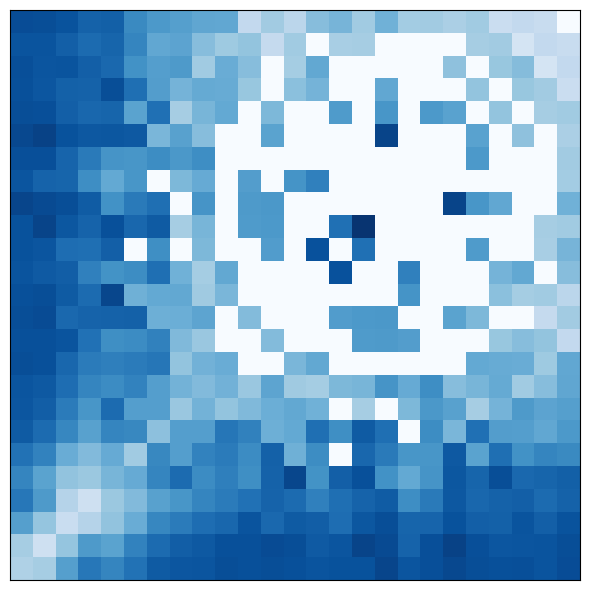

KL: 0.4963
Pair ACC: 0.9808


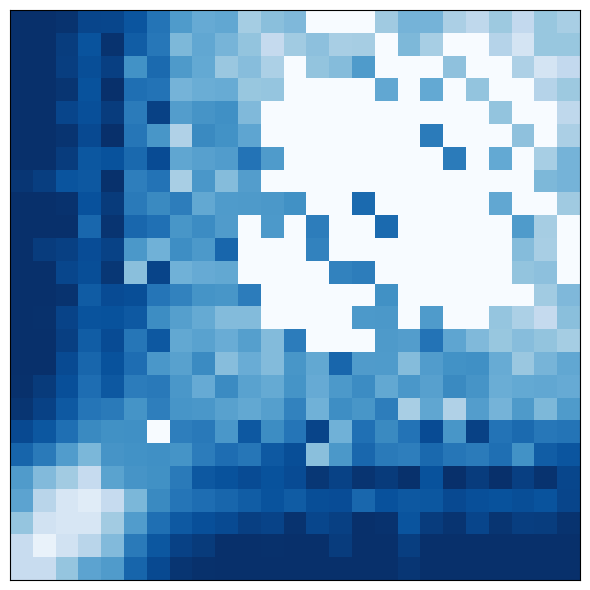

KL: 1.0162
Pair ACC: 0.9844


In [46]:
eval_feedbacks(feedbacks_z, test_pair_algo=test_pair_algo)
eval_feedbacks(feedbacks_mu, test_pair_algo=test_pair_algo)